In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "check_generated_data.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths
setup_project_paths(PATH)

from utils_plotting import plot_time_series, plot_random_monthly_and_yearly_data
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
#from utils_cumulative_distribution import calculate_global_cumulative_distribution
from utils_global_probabilities import calculate_global_probabilities
from utils_country_probabilities import calculate_all_country_probabilities
from utils_return_periods import calculate_return_periods
from utils_check_expected_features import check_expected_features    
from utils_date_index import calculate_date_from_index 

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
# load save minimal dataframes and check the expected feature agian
df_monthly = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_monthly.pkl")
df_yearly = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_yearly.pkl")

In [ ]:
def plot_time_series(df, country_ids, feature, time_periods=None, figsize=(12, 8)):
    """
    Plots time series data for a given feature and multiple countries.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    country_ids (list): List of country IDs to filter the data.
    feature (str): The feature/column to plot.
    time_periods (list, optional): List of time periods to plot. Defaults to all periods.
    figsize (tuple, optional): Figure size for the plot. Defaults to (12, 8).

    Returns:
    None
    """

    # Check that df is a pandas DataFrame and that it is not empty
    if not isinstance(df, pd.DataFrame) or df.empty:
        raise ValueError('Input data is not a valid DataFrame or is empty.')
    
    # Check that data has the country ID column
    if 'c_id' not in df.columns:
        raise ValueError('Country ID column not found in the data. Please check the data.')

    # Ensure country_ids is a list
    if not isinstance(country_ids, list):
        raise ValueError('Country IDs should be provided as a list.')

    # Check that all country_ids are in the data
    missing_ids = [cid for cid in country_ids if cid not in df['c_id'].unique()]
    if missing_ids:
        raise ValueError(f'Country IDs not found in the data: {missing_ids}')

    # Check which time unit is used in the data by seeing if month_id or year_id is in the columns
    if 'month_id' in df.columns:
        time_period = 'month_id'
    elif 'year_id' in df.columns:
        time_period = 'year_id'
    else:
        raise ValueError('Time unit not found in the data. Please check the data.')

    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")

    # Define a color palette
    palette = sns.color_palette("tab10", len(country_ids))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

    # Plot each country's time series
    for idx, country_id in enumerate(country_ids):
        # Filter by country_id
        df_filtered = df[df['c_id'] == country_id]

        # Filter by time_periods if provided
        if time_periods is not None:
            df_filtered = df_filtered[df_filtered[time_period].isin(time_periods)]

        # Aggregate data by summing the feature over time periods
        df_aggregated = df_filtered.groupby(time_period)[feature].sum().reset_index()

        # Assert that the contry-time_period data hase been summed correctly (approximate equality)
        assert np.allclose(df_filtered[feature].sum(), df_aggregated[feature].sum(), rtol=1e-5), 'Data aggregation failed.'


        # Plotting
        plt.plot(df_aggregated[time_period], df_aggregated[feature], marker=markers[idx % len(markers)], linestyle='-', 
                 label=f'Country ID: {country_id}', color=palette[idx])

    plt.title(f'Time Series Plot for {feature}', fontsize=16)
    plt.xlabel('Time Period', fontsize=14)
    plt.ylabel(feature, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(0.85, 1), fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

     # If monthly time period, get all month ids and change them using the calculate_date_from_index function
    if time_period == 'month_id':
        # Calculate the dates from the month_id
        month_dates = [calculate_date_from_index(i) for i in df_aggregated[time_period]]
    
        # Check if they start with '01' and use these for the x-tick labels
        months_labels = [month_label if month_label[:2] == '01' else '' for month_label in month_dates]
    
        # Filter the positions for the x-ticks
        labeled_positions = [pos for pos, label in zip(df_aggregated[time_period], months_labels) if label]
    
        # Set the x-ticks and their labels
        plt.xticks(labeled_positions, [label for label in months_labels if label], rotation=45)

    # for year_id only have the full year on x-axis
    if time_period == 'year_id':
        plt.xticks(df_aggregated[time_period], [i for i in df_aggregated[time_period]], rotation=45)
        

    # now insert our logo under the legende
    image = plt.imread("/home/simon/Documents/scripts/VIEWS_FAO_index/reports/logos/VIEWS_logo.png")

    # Create OffsetImage and AnnotationBbox
    imagebox = OffsetImage(image, zoom=0.3, alpha=0.7)
    ab = AnnotationBbox(imagebox, (0.8, 0.87), frameon=False, xycoords='axes fraction', zorder=3)

    # Add AnnotationBbox to the plot
    plt.gca().add_artist(ab)

    plt.tight_layout()
    plt.show()

In [4]:
country_list = df_yearly['c_id'].unique().tolist()

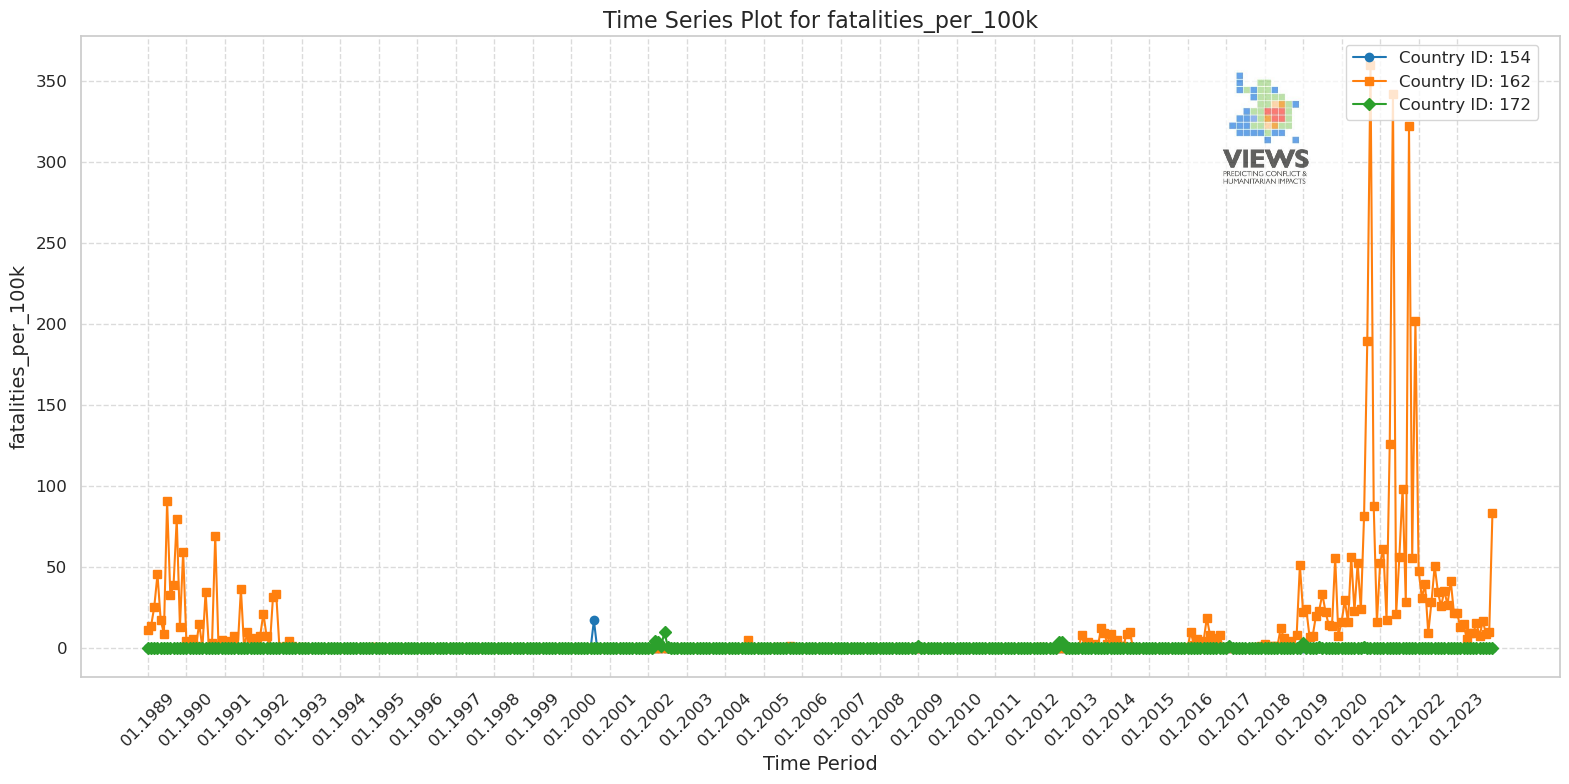

In [5]:
plot_time_series(df_monthly, country_ids=country_list[5:8], feature='fatalities_per_100k', figsize=(16, 8))

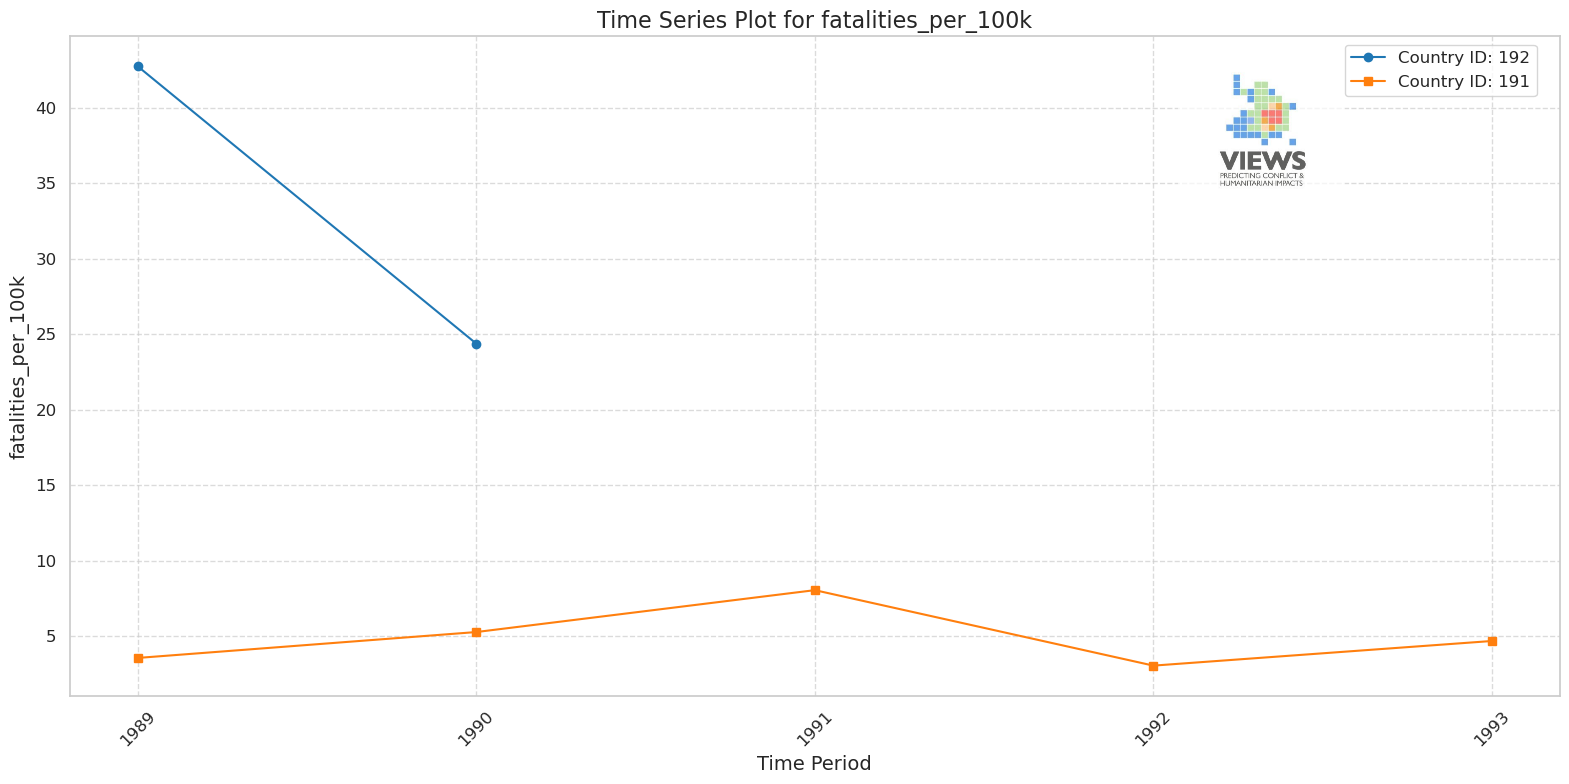

In [6]:
plot_time_series(df_yearly, country_ids=[192, 191], feature='fatalities_per_100k', figsize=(16, 8))